In [2]:
import os
import random
#from platform import architecture

import numpy as np
import pandas as pd
from numpy.f2py.cfuncs import includes

from sklearn.model_selection import train_test_split
from sympy.codegen import Print
from torchvision import transforms, models
from torchvision.transforms.functional import to_pil_image
from sklearn.model_selection import KFold, StratifiedKFold
from collections import defaultdict
from optuna import trial

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset, ConcatDataset
import optuna
import wandb
# Project utilities
import utils
from train import train_model_with_hyperparams

VGG19 = 'VGG19'
ALEXNET = 'AlexNet'

# Set seed
SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

np.random.seed(SEED)
random.seed(SEED)
# torch.backends.cudnn.deterministic = True
# torch.use_deterministic_algorithms = True

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# Check if you're working locally or not
if not (os.path.exists(utils.CSV_PATH) and os.path.exists(utils.OPTIMIZED_DIR)):
    print(f"[!] You are NOT on the project's directory [!]\n"
          f"Please run the following command (in either CMD or anaconda prompt): \n"
          f"jupyter notebook --notebook-dir PROJECT_DIR\n"
          r"Where PROJECT_DIR is the project's directory in your computer e.g: C:\Users\amitr5\PycharmProjects\deep_van_gogh")

cuda


### Loading our data
We will load the optimized datasets from our custom dataset object


In [4]:
class NumPyDataset(Dataset):
    def __init__(self, file_path):
        data = np.load(file_path)
        self.images = data["images"]
        self.labels = data["labels"]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        x = torch.tensor(self.images[idx], dtype=torch.float32)
        y = torch.tensor(self.labels[idx], dtype=torch.long)
        return x, y

dataset = NumPyDataset(os.path.join(utils.OPTIMIZED_DIR, 'dataset.npz'))

You can find the optimized dataset files <a href="https://drive.google.com/drive/folders/1TBlNcRsRHJ7_rxh_h7_yn_-Ak66Uj_mp?usp=sharing">HERE</a><br/>
Loading the train and test datasets:

In [11]:
classes = pd.read_csv(utils.CSV_PATH)
train_indices, val_indices = train_test_split(classes[classes['subset'] == 'train'].index.tolist(), test_size=0.2, random_state=SEED)
# train_indices = classes[classes['subset'] != 'test'].index.tolist()
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, classes[classes['subset'] == 'test'].index.tolist())


### Data Augmentation

In [6]:
def get_opt_dataset(dataset_name, indices=None):
    ds = NumPyDataset(os.path.join(utils.OPTIMIZED_DIR, f'{dataset_name}.npz'))
    if indices:
        ds = Subset(ds, indices)
    return ds

flip_dataset = get_opt_dataset('flip', train_indices)
dropout_dataset = get_opt_dataset('dropout',train_indices)
affine_dataset = get_opt_dataset('affine', train_indices)
blur_dataset = get_opt_dataset('blur')

augmented_train_dataset = ConcatDataset([train_dataset, flip_dataset, dropout_dataset, affine_dataset])
# augmented_train_dataset = train_dataset
# train_loader = DataLoader(augmented_train_dataset, batch_size=128, shuffle=True, num_workers=4, pin_memory=True, prefetch_factor=8)
# val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=4)

# Fine tuning VGG19

In [7]:
class FinedTunedModel(nn.Module):
    def __init__(self, base_model, architecture:str):
        super(FinedTunedModel, self).__init__()
        self._architecture = architecture  # Save the base model architecture
        base_children_list = list(base_model.children())
        self.features_extractor = nn.Sequential(*base_children_list[:-1]).to(device)
        for param in self.features_extractor.parameters():
            param.requires_grad = False

        # Modify the classifier to fit to our problem (2 classes)
        self.classifier = nn.Sequential(*base_children_list[-1])
        self.classifier[-1] = nn.Linear(4096, 2).to(device)  # Replaces the final layer of the base model's classifier with a new fully connected layer

    def forward(self, x):
        base_model_output = self.features_extractor(x)
        return self.classifier(torch.flatten(base_model_output, start_dim=1))
    @property
    def architecture(self):
        return self._architecture



In [8]:
vgg19 = models.vgg19(weights=models.VGG19_Weights.DEFAULT).to(device) # Load pre-trained VGG19 model
alexnet = models.alexnet(weights=models.AlexNet_Weights.DEFAULT).to(device)
vgg_model = FinedTunedModel(vgg19, VGG19).to(device)
vgg_model

FinedTunedModel(
  (features_extractor): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inpla

In [8]:
import torch
from torchvision import transforms
from PIL import Image

# Define the image preprocessing steps
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Function to load and preprocess the image
def load_and_preprocess_image(img_path):
    input_image = Image.open(img_path).convert('RGB')
    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0)  # Create a mini-batch as expected by the model
    return input_batch

# Function to activate the model on the image and print the result
def activate_model_on_image(model, img_path, device):
    model.eval()  # Set the model to evaluation mode
    input_batch = load_and_preprocess_image(img_path).to(device)

    with torch.no_grad():
        output = model(input_batch)

    # Print the raw output
    print("Model output:", output)
    return output

# Example usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
img_path = r'D:\Users\ghefter\PycharmProjects\deep_van_gogh\data\dataset\Post_Impressionism\vincent-van-gogh_garden-with-flowers-1888-1(1).jpg'
output=activate_model_on_image(vgg_model, img_path, device)
print(output[0,0])
print(torch.max(output,0))

FileNotFoundError: [Errno 2] No such file or directory: 'D:\\Users\\ghefter\\PycharmProjects\\deep_van_gogh\\data\\dataset\\Post_Impressionism\\vincent-van-gogh_garden-with-flowers-1888-1(1).jpg'

In [43]:
def cross_validation(dataset, learning_rate, weight_decay, criterion, epochs, patience, device, architecture, trial):
    # Initialize KFold
    k_folds = 4
    kfold = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

    # Track performance for each model
    results = defaultdict(list)
    base_model = vgg19 if architecture == VGG19 else alexnet

    best_values = []
    # indices = dataset.indices
    # labels = dataset.dataset.labels[indices]
    indices = np.arange(len(dataset))
    labels = np.tile(train_dataset.dataset.labels[train_dataset.indices],len(dataset.datasets))
    for fold, (train_ids, val_ids) in enumerate(kfold.split(indices, labels)):
        #########
        wandb.init(project='deep_van_gogh-aug-2',
                       config={ "learning_rate": learning_rate,
                                "weight_decay": weight_decay,
                                "patience": patience,
                                "batch_size": 128,
                                "epochs": epochs,
                                "architecture": architecture,
                                "dataset": "Post_Impressionism",
                                }, name=f"{architecture}_trial_{trial.number + 1}_fold_{fold}")
        ################


        train_subset = Subset(dataset, train_ids)
        val_subset = Subset(dataset, val_ids)

        # Create data loaders
        train_loader = DataLoader(train_subset, batch_size=128, pin_memory=True, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=128, pin_memory=True, shuffle=False)
        model = FinedTunedModel(base_model.to(device), architecture).to(device)

        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        # Train the model
        best_val = train_model_with_hyperparams(model,
                                                train_loader,
                                                val_loader,
                                                optimizer,
                                                criterion,
                                                epochs=epochs,
                                                patience=patience,
                                                device=device,
                                                trial=trial,
                                                architecture=architecture, fold=fold)
        wandb.log({'Fold': fold, 'AUC':best_val})
        best_values.append(best_val)
        # Finish the Weights & Biases run
        wandb.finish()

    return np.mean(best_values)

In [57]:
# Optuna objective function
def objective(trial, model, config: dict) -> float:
    """
    Generic Optuna objective function.
    :param trial: Optuna trial object.
    :param model: The neural network model to train
    :param config: A dictionary with configurable values such as learning rate ranges, batch size ranges, etc.
    :return:  best_val_loss: The best validation loss achieved during training.
    """
    # Hyperparameter suggestions based on config
    learning_rate = trial.suggest_float("learning_rate",
                                        config.get("lr_min", 1e-5),
                                        config.get("lr_max", 1e-3),
                                        log=True)
    weight_decay = trial.suggest_float("weight_decay",
                                       config.get("wd_min", 1e-6),
                                       config.get("wd_max", 1e-4),
                                       log=True)
    # batch_size = trial.suggest_int("batch_size",
    #                                config.get("batch_size_min", 32),
    #                                config.get("batch_size_max", 128),
    #                                step=config.get("batch_size_step", 16))
    epochs = trial.suggest_int("epochs", config.get("epochs_min", 10), config.get("epochs_max",30))
    patience = config.get("patience", 8)

    # train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # Load the train DataLoader with the chosen batch_size
    # val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False) # Load the val DataLoader with the chosen batch_size

    # Define optimizer and loss function
    criterion = config.get("criterion", nn.CrossEntropyLoss()) # Classification.

    # optimizer_class = config.get("optimizer_class", optim.Adam)
    # optimizer = optimizer_class(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Initialize Weights & Biases - the values in the config are the properties of each trial.
    architecture = getattr(model, "architecture", model.__class__.__name__)
    # wandb.init(project="deep_van_gogh",
    #            config={
    #     "learning_rate": learning_rate,
    #     "weight_decay": weight_decay,
    #     "patience": patience,
    #     "batch_size": batch_size,
    #     "epochs": epochs,
    #     "architecture": architecture,
    #     "dataset": "Post_Impressionism"
    # },
    # name=f"{architecture}_trial_{trial.number+1}") # The name that will be saved in the W&B platform

    # Train the model and get the best val_auc
    # mean_val = cross_validation(train_dataset, learning_rate, weight_decay, criterion, epochs, patience, device, architecture, trial)
    mean_val = cross_validation(augmented_train_dataset, learning_rate, weight_decay, criterion, epochs, patience, device, architecture, trial)
    #print(mean_val)
    wandb.init(project='deep_van_gogh-aug-2',
                       config={ "learning_rate": learning_rate,
                                "weight_decay": weight_decay,
                                "patience": patience,
                                "batch_size": 128,
                                "epochs": epochs,
                                "architecture": architecture,
                                "dataset": "Post_Impressionism",
                                }, name=f"{architecture}_trial_{trial.number + 1}")
    wandb.log({'Trial': trial.number+1, 'Mean AUC': mean_val})
    wandb.finish()
    # mean_val = train_model_with_hyperparams(model, train_loader, learning_rate, weight_decay, criterion,
    #                                              epochs=epochs, patience=patience, device=device, trial=trial,
    #                                              architecture=architecture)



    # Return best validation loss as the objective to minimize
    return mean_val



In [58]:
# Optuna for our vgg model with the default config
study = optuna.create_study(study_name=VGG19, direction='maximize')
study.optimize(lambda trial: objective(trial, vgg_model, config={}), n_trials=15)

[I 2025-03-24 21:02:32,263] A new study created in memory with name: VGG19
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: amitr5 (amitr5-tel-aviv-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


[W 2025-03-24 21:03:17,576] Trial 0 failed with parameters: {'learning_rate': 0.0003578498492933724, 'weight_decay': 2.5628401075200825e-05} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "C:\Users\amitr5\.conda\envs\DeepLearning_env\lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\amitr5\AppData\Local\Temp\ipykernel_18336\2319463337.py", line 3, in <lambda>
    study.optimize(lambda trial: objective(trial, vgg_model, config={}), n_trials=15)
  File "C:\Users\amitr5\AppData\Local\Temp\ipykernel_18336\1015064751.py", line 51, in objective
    mean_val = cross_validation(augmented_train_dataset, learning_rate, weight_decay, criterion, epochs, patience, device, architecture, trial)
  File "C:\Users\amitr5\AppData\Local\Temp\ipykernel_18336\2664636608.py", line 39, in cross_validation
    best_val = train_model_with_hyperparams(model,
  File "C:\Users\amitr5\PycharmProjec

KeyboardInterrupt: 

## Cross-Validation

In [9]:
# Training the model - ALEXNET
train_loader = DataLoader(train_dataset, batch_size=128, pin_memory=True, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, pin_memory=True, shuffle=False)
base_model = alexnet
model = FinedTunedModel(base_model.to(device), ALEXNET).to(device)
weight_decay=0.0000961196621799138
lr=0.0000607994047379646
optimizer = optim.Adam(model.parameters(), lr=0.0000607994047379646, weight_decay=0.0000961196621799138)
criterion = nn.CrossEntropyLoss()

wandb.init(project='deep_van_gogh-best',
                       config={ "learning_rate": lr,
                                "weight_decay": weight_decay,
                                "patience": 8,
                                "batch_size": 128,
                                "epochs": 15,
                                "architecture": ALEXNET,
                                "dataset": "Post_Impressionism",
                                }, name=f"{ALEXNET}-best")
        ################
train_model_with_hyperparams(model, train_loader, val_loader, optimizer, criterion, epochs=15, patience=8,device=device, trial=None, architecture=ALEXNET, fold=0, save_model=True)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: amitxy (amitxy-tel-aviv-university). Use `wandb login --relogin` to force relogin


0.9614512471655329

In [18]:

val_loss = 0.0 # Same initialization as in the train
total_val_samples = 0 # Same initialization as in the train
correct_val_predictions = 0 # Same initialization as in the train
### TEST ####
val_loader = DataLoader(test_dataset, batch_size=128, pin_memory=True, shuffle=False)
# For AUC calculation - pre-allocate arrays
all_val_labels = torch.zeros(len(val_loader.dataset), dtype=torch.long)
all_val_probs = torch.zeros(len(val_loader.dataset), dtype=torch.float32)
all_val_preds = torch.zeros(len(val_loader.dataset), dtype=torch.float32)
idx = 0

# test_dataset = Subset(dataset, classes[classes['subset'] == 'test'].index.tolist())
#   train_subset = Subset(dataset, train_ids)
#         val_subset = Subset(dataset, val_ids)
model.eval()
with torch.no_grad():  # Disable gradient computation
    for inputs, labels in val_loader: # iterate on the val_loader's batches
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        val_loss += loss.item() * inputs.size(0)
        total_val_samples += inputs.size(0)
        # Calculate correct predictions for validation accuracy
        _, predicted = torch.max(outputs, 1)
        correct_val_predictions += (predicted == labels).sum().item()

        # Get probabilities using softmax
        probs = torch.softmax(outputs, dim=1)[:, 1]
        # Store in pre-allocated arrays
        batch_size = labels.size(0)
        all_val_labels[idx:idx + batch_size] = labels.cpu()
        all_val_probs[idx:idx + batch_size] = probs.cpu()
        all_val_preds[idx:idx + batch_size] = predicted.cpu()
        idx += batch_size

# Calculate average validation loss and accuracy
val_loss /= total_val_samples
val_accuracy = correct_val_predictions / total_val_samples

val_auc = roc_auc_score(all_val_labels.numpy(), all_val_probs.numpy())

val_F1 = f1_score(all_val_labels.numpy(), all_val_preds.numpy(),average='weighted')

val_precision = precision_score(all_val_labels.numpy(), all_val_preds.numpy(),average='weighted')

val_recall = recall_score(all_val_labels.numpy(), all_val_preds.numpy(),average='weighted')

tn, fp, fn, tp = confusion_matrix(all_val_labels.numpy(), all_val_preds).ravel()
val_specificity = tn / (tn + fp)


128
256
384
512
640
768
896


IndexError: index 4551 is out of bounds for axis 0 with size 4551

In [14]:
def cross_validation_temp(dataset:Dataset, **models_dict):
    # Initialize KFold
    k_folds = 5
    kfold = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

    # Track performance for each model
    results = defaultdict(list)

    for fold, (train_ids, val_ids) in enumerate(kfold.split(dataset)):
            #print(f"\tFold {fold + 1}")
            # Subset the dataset for this fold
            train_subset = Subset(dataset, train_ids)
            val_subset = Subset(dataset, val_ids)

            # Create data loaders
            train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
            val_loader = DataLoader(val_subset, batch_size=64, shuffle=False)

            for model_name, model_dict in models_dict.items():
                #print(f"Training :{model_name}")
                # Load the entire model
                base_model = vgg19 if model_dict["architecture"] == VGG19 else alexnet
                model = FinedTunedModel(base_model.to(device), model_dict["architecture"]).to(device)

                # Define loss function and optimizer
                criterion = nn.CrossEntropyLoss()
                optimizer = optim.Adam(model.parameters(), **model_dict['param_groups'])



                # Train the model (implement your training loop here)
                best_val = train_model_with_hyperparams(model, train_loader, val_loader, optimizer, criterion,
                                                             epochs=3, patience=3, device=device, trial=None,
                                                             architecture=None)
                 # Append the results for this fold
                results[model_name].append(best_val)


    # Print final results
    mean_perf_dict = {}
    for model_name, model_results in results.items():
         # After all folds, calculate the average fold performance
        mean_perf = sum(results[model_name]) / len(results[model_name])
        print(f"Average Performance for {model_name}: {mean_perf}")

        print(f"{model_name} - Cross-Validation Results: {model_results}")
        print(f"{model_name} - Mean Performance: {sum(model_results) / len(model_results)}")
        mean_perf_dict[model_name] = mean_perf

    return mean_perf_dict

In [48]:
vgg_path = os.path.join(utils.MODELS_DIR, VGG19)

def get_hyperparameters(path):
    param_groups = torch.load(path, weights_only=True)['optimizer_state_dict']['param_groups'][0]
    return {'lr':param_groups['lr'], 'weight_decay':param_groups['weight_decay']}


model1_param_groups = get_hyperparameters(f"{vgg_path}/best_model_trial_0.pt") # Load hyperparameters
model1_dict = {
    'architecture': VGG19,
    'param_groups': model1_param_groups
}


model2_param_groups =  get_hyperparameters(f"{vgg_path}/best_model_trial_1.pt") # Load hyperparameters
model2_dict = {
    'architecture': VGG19,
    'param_groups': model2_param_groups
}


cross_validation(train_dataset, vgg_model1=model1_dict, vgg_model2=model2_dict)


	Fold 1
Training :vgg_model1



KeyboardInterrupt



# Fine tuning AlexNet

In [7]:
# Load the AlexNet model 
alexnet = models.alexnet(weights=models.AlexNet_Weights.DEFAULT).to(device)
alexnet_model = FinedTunedModel(alexnet, ALEXNET).to(device)
alexnet_model

FinedTunedModel(
  (features_extractor): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): AdaptiveAvgPool2d(output_size=(6, 6))
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False

In [8]:
study = optuna.create_study(study_name=f'{ALEXNET}', direction='minimize')
study.optimize(lambda trial: objective(trial, alexnet_model, config={}), n_trials=3)

[I 2025-01-22 16:01:36,164] A new study created in memory with name: AlexNet
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: amitr5 (amitr5-tel-aviv-university). Use `wandb login --relogin` to force relogin


Epoch,▁▃▅▆█
Train Accuracy,▁▅▆▇█
Train Loss,█▃▂▁▁
Validation Accuracy,▁█▆▇▆
Validation Loss,█▁▅▂▅
Epoch,5
Train Accuracy,0.99795
Train Loss,0.01104
Validation Accuracy,0.96854
Validation Loss,0.11455


[I 2025-01-22 16:01:57,725] Trial 0 finished with value: 0.10576229227551358 and parameters: {'learning_rate': 8.54475681264745e-05, 'weight_decay': 1.3246324576641997e-06, 'batch_size': 96}. Best is trial 0 with value: 0.10576229227551358.


Epoch,▁▃▅▆█
Train Accuracy,▁▅▆▇█
Train Loss,█▃▂▂▁
Validation Accuracy,▅█▁▄▃
Validation Loss,▂▂▂▁█
Epoch,5
Train Accuracy,0.98598
Train Loss,0.04482
Validation Accuracy,0.95896
Validation Loss,0.3491


[I 2025-01-22 16:02:24,856] Trial 1 finished with value: 0.12651337678614297 and parameters: {'learning_rate': 0.00035744717416844876, 'weight_decay': 3.63939834492625e-06, 'batch_size': 32}. Best is trial 0 with value: 0.10576229227551358.


Epoch,▁▃▅▆█
Train Accuracy,▁▅▇██
Train Loss,█▃▁▁▁
Validation Accuracy,▁▇▄█▅
Validation Loss,▅▁█▁▃
Epoch,5
Train Accuracy,0.98324
Train Loss,0.05421
Validation Accuracy,0.95896
Validation Loss,0.1584


[I 2025-01-22 16:02:50,670] Trial 2 finished with value: 0.131821774687776 and parameters: {'learning_rate': 0.0008391974354331484, 'weight_decay': 9.707033483493868e-05, 'batch_size': 32}. Best is trial 0 with value: 0.10576229227551358.


analysing results

# Style transfer function

In [24]:
import tqdm

from matplotlib import pyplot as plt
from PIL import Image
#define a function to load an image and pre-process it
def load_image(img_path, shape=(224,224)):
    image = Image.open(img_path).convert('RGB')
    # Define transformation to resize, normalize, and convert to tensor
    in_transform = transforms.Compose([
        transforms.Resize(shape),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])
    # Apply transformations, remove alpha channel, and add batch dimension
    image = in_transform(image)[:3, :, :].unsqueeze(0)
    return image.to(device)
#define a function to extract features from the network
def get_features(image, model, layers):
    features = {}
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
    return features
def gram_matrix(tensor):
    _, d, h, w = tensor.size()
    tensor = tensor.view(d, h * w)
    gram = torch.mm(tensor, tensor.t())
    return gram

# Deprocess the image by reversing the normalization
def deprocess(tensor):
    tensor = tensor.cpu().clone().detach()
    tensor = tensor.squeeze(0)
    tensor = tensor * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    tensor = torch.clamp(tensor, 0, 1)
    return to_pil_image(tensor)


In [ ]:

def style_transfer(model, style_img_path, content_img_path, content_weight=1, style_weight=1e3, num_steps=5001, model_name='vgg19_pretrained'):
    model = model.features #Gives us access to the layers of features

    layers = {
         '0': 'conv1_1', '5': 'conv2_1', '10': 'conv3_1', '19': 'conv4_1',
         '21': 'conv4_2'
    }

    style_weights = {
        'conv1_1': 0.5, 'conv2_1': 0.5, 'conv3_1': 0.5, 'conv4_1': 0.3
    }

    content_layer = 'conv4_2'
    # Prepare model for evaluation, disabling gradient computation
    model.to(device).eval()
    for param in model.parameters():
         param.requires_grad_(False)
    # Load and preprocess the content and style images
    content = load_image(content_img_path).to(device)
    style = load_image(style_img_path).to(device)
    # Extract features from content and style images
    content_features = get_features(content, model, layers)
    style_features = get_features(style, model, layers)
    target = content.clone().requires_grad_(True).to(device)

    style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}
    optimizer = optim.Adam([target], lr=0.003)

    # Initialize list to track losses
    losses = []
    # Style transfer loop
    for ii in tqdm.tqdm(range(1, num_steps + 1), desc="Style Transfer Progress"):
        # Extract features from target image
        target_features = get_features(target, model, layers)

        # Compute content loss
        content_loss = torch.mean((target_features[content_layer] - content_features[content_layer])**2)

        # Compute style loss by comparing Gram matrices for each layer
        style_loss = 0
        for layer in style_weights:
            target_feature = target_features[layer]
            target_gram = gram_matrix(target_feature)
            _, d, h, w = target_feature.shape
            style_gram = style_grams[layer]
            layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
            style_loss += layer_style_loss / (d * h * w)
        # Calculate total loss and update target image
        total_loss = content_weight * content_loss + style_weight * style_loss
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        # Track the loss
        if ii % 1000 == 0:
            losses.append(total_loss.item())
            print(f"Step {ii}, Total loss: {total_loss.item()}")

    # Plot the loss
    #plt.plot(range(0, len(losses) * 100, 100), losses)
    #plt.xlabel('Step')
    #plt.ylabel('Total Loss')
    #plt.title('Loss during Style Transfer')
    #plt.show()

    return target



def style_transfer2(model, style_img_path, content_img_path, layers, style_weights, content_layer, content_weight=1, style_weight=1e3, num_steps=5001,shape=(224,224)):
    model = model.features  # Gives us access to the layers of features

    # Prepare model for evaluation, disabling gradient computation
    model.to(device).eval()
    for param in model.parameters():
        param.requires_grad_(False)
    # Load and preprocess the content and style images
    content = load_image(content_img_path,shape).to(device)
    style = load_image(style_img_path,shape).to(device)
    # Extract features from content and style images
    content_features = get_features(content, model, layers)
    style_features = get_features(style, model, layers)
    target = content.clone().requires_grad_(True).to(device)

    style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}
    optimizer = optim.Adam([target], lr=0.003)

    # Initialize list to track losses
    losses = []
    # Style transfer loop
    for ii in tqdm.tqdm(range(1, num_steps + 1), desc="Style Transfer Progress"):
        # Extract features from target image
        target_features = get_features(target, model, layers)

        # Compute content loss
        content_loss = torch.mean((target_features[content_layer] - content_features[content_layer])**2)

        # Compute style loss by comparing Gram matrices for each layer
        style_loss = 0
        for layer in style_weights:
            target_feature = target_features[layer]
            target_gram = gram_matrix(target_feature)
            _, d, h, w = target_feature.shape
            style_gram = style_grams[layer]
            layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
            style_loss += layer_style_loss / (d * h * w)
        # Calculate total loss and update target image
        total_loss = content_weight * content_loss + style_weight * style_loss
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        # Track the loss
        if ii % 1000 == 0:
            losses.append(total_loss.item())
            print(f"Step {ii}, Total loss: {total_loss.item()}")

    return target


def style_transfer_multi_style(model, style_img_paths, style_weights, content_img_path, layers, style_layer_weights, content_layer, content_weight=1, style_weight=1e3, num_steps=5001, shape=(224,224)):
    model = model.features  # Gives us access to the layers of features

    # Prepare model for evaluation, disabling gradient computation
    model.to(device).eval()
    for param in model.parameters():
        param.requires_grad_(False)

    # Load and preprocess the content image
    content = load_image(content_img_path, shape).to(device)
    content_features = get_features(content, model, layers)

    # Load and preprocess the style images
    style_features_list = []
    for style_img_path in style_img_paths:
        style = load_image(style_img_path, shape).to(device)
        style_features = get_features(style, model, layers)
        style_features_list.append(style_features)

    # Combine style features by weighted averaging
    combined_style_features = {}
    for layer in layers.values():
        combined_style_features[layer] = torch.zeros_like(style_features_list[0][layer])
        for i, style_features in enumerate(style_features_list):
            combined_style_features[layer] += style_weights[i] * style_features[layer]
        combined_style_features[layer] /= sum(style_weights)

    target = content.clone().requires_grad_(True).to(device)
    style_grams = {layer: gram_matrix(combined_style_features[layer]) for layer in combined_style_features}
    optimizer = optim.Adam([target], lr=0.003)

    # Initialize list to track losses
    losses = []
    # Style transfer loop
    for ii in tqdm.tqdm(range(1, num_steps + 1), desc="Style Transfer Progress"):
        # Extract features from target image
        target_features = get_features(target, model, layers)

        # Compute content loss
        content_loss = torch.mean((target_features[content_layer] - content_features[content_layer])**2)

        # Compute style loss by comparing Gram matrices for each layer
        style_loss = 0
        for layer in style_layer_weights:
            target_feature = target_features[layer]
            target_gram = gram_matrix(target_feature)
            _, d, h, w = target_feature.shape
            style_gram = style_grams[layer]
            layer_style_loss = style_layer_weights[layer] * torch.mean((target_gram - style_gram)**2)
            style_loss += layer_style_loss / (d * h * w)

        # Calculate total loss and update target image
        total_loss = content_weight * content_loss + style_weight * style_loss
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        # Track the loss
        if ii % 1000 == 0:
            losses.append(total_loss.item())
            print(f"Step {ii}, Total loss: {total_loss.item()}")

            # Deprocess and display the intermediate result
            intermediate_result = deprocess(target)
            plt.imshow(intermediate_result)
            plt.title(f"Step {ii}")
            plt.axis('off')
            plt.show()

    return target

Style Transfer Progress:  20%|█▉        | 998/5001 [00:24<01:38, 40.77it/s]

Step 1000, Total loss: 4274274048.0


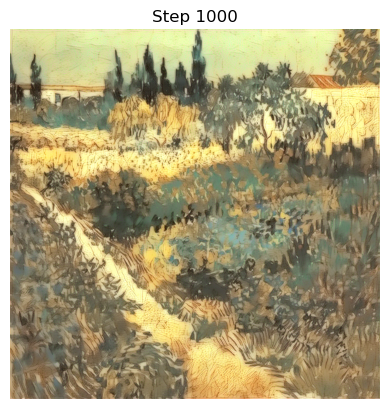

Style Transfer Progress:  40%|███▉      | 1999/5001 [00:48<01:14, 40.18it/s]

Step 2000, Total loss: 1764920576.0


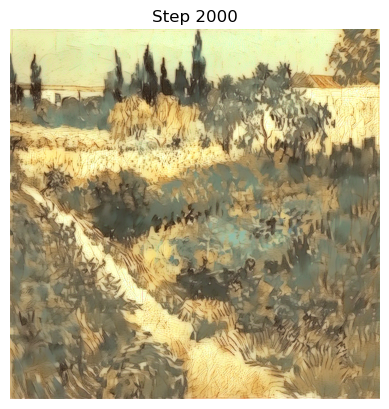

Style Transfer Progress:  60%|█████▉    | 2998/5001 [01:13<00:49, 40.48it/s]

Step 3000, Total loss: 1046685760.0


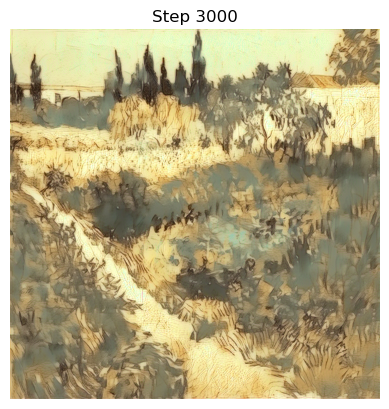

Style Transfer Progress:  80%|███████▉  | 3999/5001 [01:38<00:25, 39.85it/s]

Step 4000, Total loss: 608836416.0


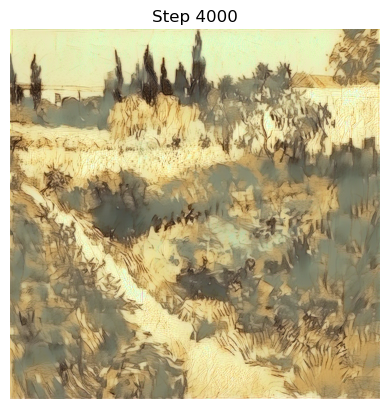

Style Transfer Progress: 100%|█████████▉| 4997/5001 [02:03<00:00, 41.09it/s]

Step 5000, Total loss: 318606912.0


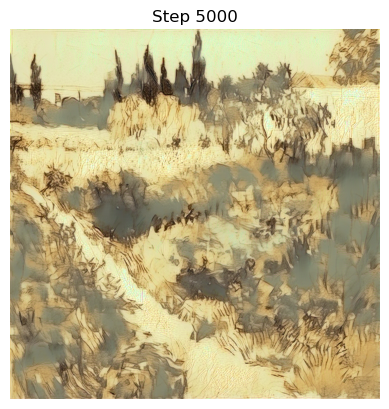

Style Transfer Progress: 100%|██████████| 5001/5001 [02:03<00:00, 40.49it/s]


In [62]:
# Load the style and content images
style_img_paths = [r'D:\Users\ghefter\PycharmProjects\deep_van_gogh\data\dataset\Post_Impressionism\vincent-van-gogh_canal(1).jpg']

content_img_path = r'D:\Users\ghefter\PycharmProjects\deep_van_gogh\data\dataset\Post_Impressionism\vincent-van-gogh_garden-with-flowers-1888-1(1).jpg'
style_weights=[1]
# define the model
model = vgg19
#define style layers and weights
layers = {
         '0': 'conv1_1', '5': 'conv2_1', '10': 'conv3_1', '19': 'conv4_1',
         '21': 'conv4_2'
    }

style_layer_weights = {
        'conv1_1': 10, 'conv2_1': 5, 'conv3_1': 1, 'conv4_1': 0.3
    }

content_layer = 'conv4_2'
# Perform style transfer
stylized_image = style_transfer_multi_style(model, style_img_paths=style_img_paths,style_weights=style_weights, content_img_path=content_img_path,style_weight=1e8, content_weight=0,num_steps=5001,layers=layers,style_layer_weights=style_layer_weights,content_layer=content_layer,shape=(800,800))

# Deprocess and display the image
stylized_image = deprocess(stylized_image)

# Load the original content image to get its resolution
#original_content_image = Image.open(content_img_path)
#original_resolution = original_content_image.size

# Resize the stylized image to the original resolution
#stylized_image = stylized_image.resize(original_resolution, Image.LANCZOS)

# Display the upscaled image
stylized_image.show()
output_path = r'D:\Users\ghefter\PycharmProjects\deep_van_gogh\data\stylized images\output2.jpg'
stylized_image.save(output_path)



In [6]:
import os

# Set the working directory
desired_path = r'D:\Users\ghefter\PycharmProjects\deep_van_gogh'
os.chdir(desired_path)

# Verify the current working directory
print(f"Current working directory: {os.getcwd()}")

Current working directory: D:\Users\ghefter\PycharmProjects\deep_van_gogh


In [17]:
import os

# Correct file path using raw strings
file_path = r'D:\Users\ghefter\PycharmProjects\deep_van_gogh\data\dataset\Post_Impressionism\edouard-cortes_theatre-du-chatelet-1.jpg'

# Ensure the path is correct
if not os.path.exists(file_path):
    print(f"File not found: {file_path}")
else:
    print(f"File found: {file_path}")
    # Open the file
    with open(file_path, "rb") as fp:
        content = fp.read()
        print("File opened successfully")

File found: D:\Users\ghefter\PycharmProjects\deep_van_gogh\data\dataset\Post_Impressionism\edouard-cortes_theatre-du-chatelet-1.jpg
File opened successfully
